In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs

In [2]:
input_path = '../input/'
cams_data_path = input_path + 'cams_aq_data/'

ds_aq = xr.open_mfdataset(cams_data_path + '/*.nc')
ds_aq

/opt/anaconda3/envs/air/lib/python3.10/site-packages/dask/array/core.py:4894: PerformanceWarning: Increasing number of chunks by factor of 521
  result = blockwise(


<xarray.Dataset> Size: 10GB
Dimensions:  (time: 744, lon: 1258, lat: 521)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2023-03-01 ... 2023-03-31T23:00:00
  * lon      (lon) float64 10kB -24.95 -24.85 -24.85 ... 44.75 44.85 44.95
  * lat      (lat) float64 4kB 30.05 30.15 30.15 30.25 ... 71.85 71.85 71.95
Data variables:
    no2      (time, lat, lon) float32 2GB dask.array<chunksize=(744, 521, 700), meta=np.ndarray>
    o3       (time, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 700), meta=np.ndarray>
    pm10     (time, lat, lon) float32 2GB dask.array<chunksize=(744, 521, 700), meta=np.ndarray>
    pm2p5    (time, lat, lon) float32 2GB dask.array<chunksize=(744, 521, 700), meta=np.ndarray>
    so2      (time, lat, lon) float32 2GB dask.array<chunksize=(744, 521, 700), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service

In [3]:
ds_aq_monthly = ds_aq.resample(time='ME').mean()
ds_aq_monthly = ds_aq_monthly.squeeze(drop=True)
ds_aq_monthly

<xarray.Dataset> Size: 13MB
Dimensions:  (lat: 521, lon: 1258)
Coordinates:
  * lon      (lon) float64 10kB -24.95 -24.85 -24.85 ... 44.75 44.85 44.95
  * lat      (lat) float64 4kB 30.05 30.15 30.15 30.25 ... 71.85 71.85 71.95
Data variables:
    no2      (lat, lon) float32 3MB dask.array<chunksize=(521, 700), meta=np.ndarray>
    o3       (lat, lon) float32 3MB dask.array<chunksize=(1, 700), meta=np.ndarray>
    pm10     (lat, lon) float32 3MB dask.array<chunksize=(521, 700), meta=np.ndarray>
    pm2p5    (lat, lon) float32 3MB dask.array<chunksize=(521, 700), meta=np.ndarray>
    so2      (lat, lon) float32 3MB dask.array<chunksize=(521, 700), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service

In [4]:
no2_limits = [0, 40, 90, 120, 230, 340, 1000]
o3_limits = [0, 50, 100, 130, 240, 380, 800]
pm10_limits = [0, 10, 20, 25, 50, 75, 800]
pm2p5_limits = [0, 20, 40, 50, 100, 150, 1200]
so2_limits = [0, 100, 200, 350, 500, 750, 1250]

bin_list = [no2_limits, o3_limits, pm10_limits, pm2p5_limits, so2_limits]
bin_list

[[0, 40, 90, 120, 230, 340, 1000],
 [0, 50, 100, 130, 240, 380, 800],
 [0, 10, 20, 25, 50, 75, 800],
 [0, 20, 40, 50, 100, 150, 1200],
 [0, 100, 200, 350, 500, 750, 1250]]

In [5]:
ds_var = ['no2', 'o3', 'pm10', 'pm2p5', 'so2']
ds_var

['no2', 'o3', 'pm10', 'pm2p5', 'so2']

In [6]:
classified_arrays = []
for i in range(len(ds_var)):
    variable = ds_var[i]
    data_array = ds_aq_monthly[variable].values
    bins = bin_list[i]
    temp = np.digitize(data_array, bins)

    classified_arrays.append(xr.DataArray(temp, coords=ds_aq_monthly[variable].coords, dims=ds_aq_monthly[variable].dims, name=f"{variable}_classified"))

In [7]:
merge_classified = xr.merge(classified_arrays)
merge_classified

<xarray.Dataset> Size: 26MB
Dimensions:           (lon: 1258, lat: 521)
Coordinates:
  * lon               (lon) float64 10kB -24.95 -24.85 -24.85 ... 44.85 44.95
  * lat               (lat) float64 4kB 30.05 30.15 30.15 ... 71.85 71.85 71.95
Data variables:
    no2_classified    (lat, lon) int64 5MB 1 7 1 1 1 1 1 7 1 ... 7 1 7 1 7 1 1 1
    o3_classified     (lat, lon) int64 5MB 2 2 7 2 2 2 2 2 7 ... 2 7 2 7 2 7 2 2
    pm10_classified   (lat, lon) int64 5MB 2 7 2 2 2 2 2 7 2 ... 7 1 7 1 7 1 1 1
    pm2p5_classified  (lat, lon) int64 5MB 1 7 1 1 1 1 1 7 1 ... 7 1 7 1 7 1 1 1
    so2_classified    (lat, lon) int64 5MB 1 7 1 1 1 1 1 7 1 ... 7 1 7 1 7 1 1 1

In [8]:
aq_index = merge_classified.to_array().mean('variable').astype(int)
aq_index.to_netcdf('../intermediates/aq_index.nc')
aq_index

<xarray.DataArray (lat: 521, lon: 1258)> Size: 5MB
array([[1, 6, 2, ..., 3, 2, 2],
       [6, 6, 7, ..., 7, 6, 6],
       [2, 7, 2, ..., 3, 3, 3],
       ...,
       [6, 6, 7, ..., 7, 6, 6],
       [2, 7, 2, ..., 2, 2, 2],
       [1, 6, 2, ..., 2, 1, 1]])
Coordinates:
  * lon      (lon) float64 10kB -24.95 -24.85 -24.85 ... 44.75 44.85 44.95
  * lat      (lat) float64 4kB 30.05 30.15 30.15 30.25 ... 71.85 71.85 71.95

In [9]:
cmap = ListedColormap(['#5AAA5F', '#A7D25C', '#ECD347', '#F5BE41', '#F09235', '#D93322'])
labels = ['Very good', 'Good', 'Medium', 'Poor', 'Very Poor', 'Extremely Poor']

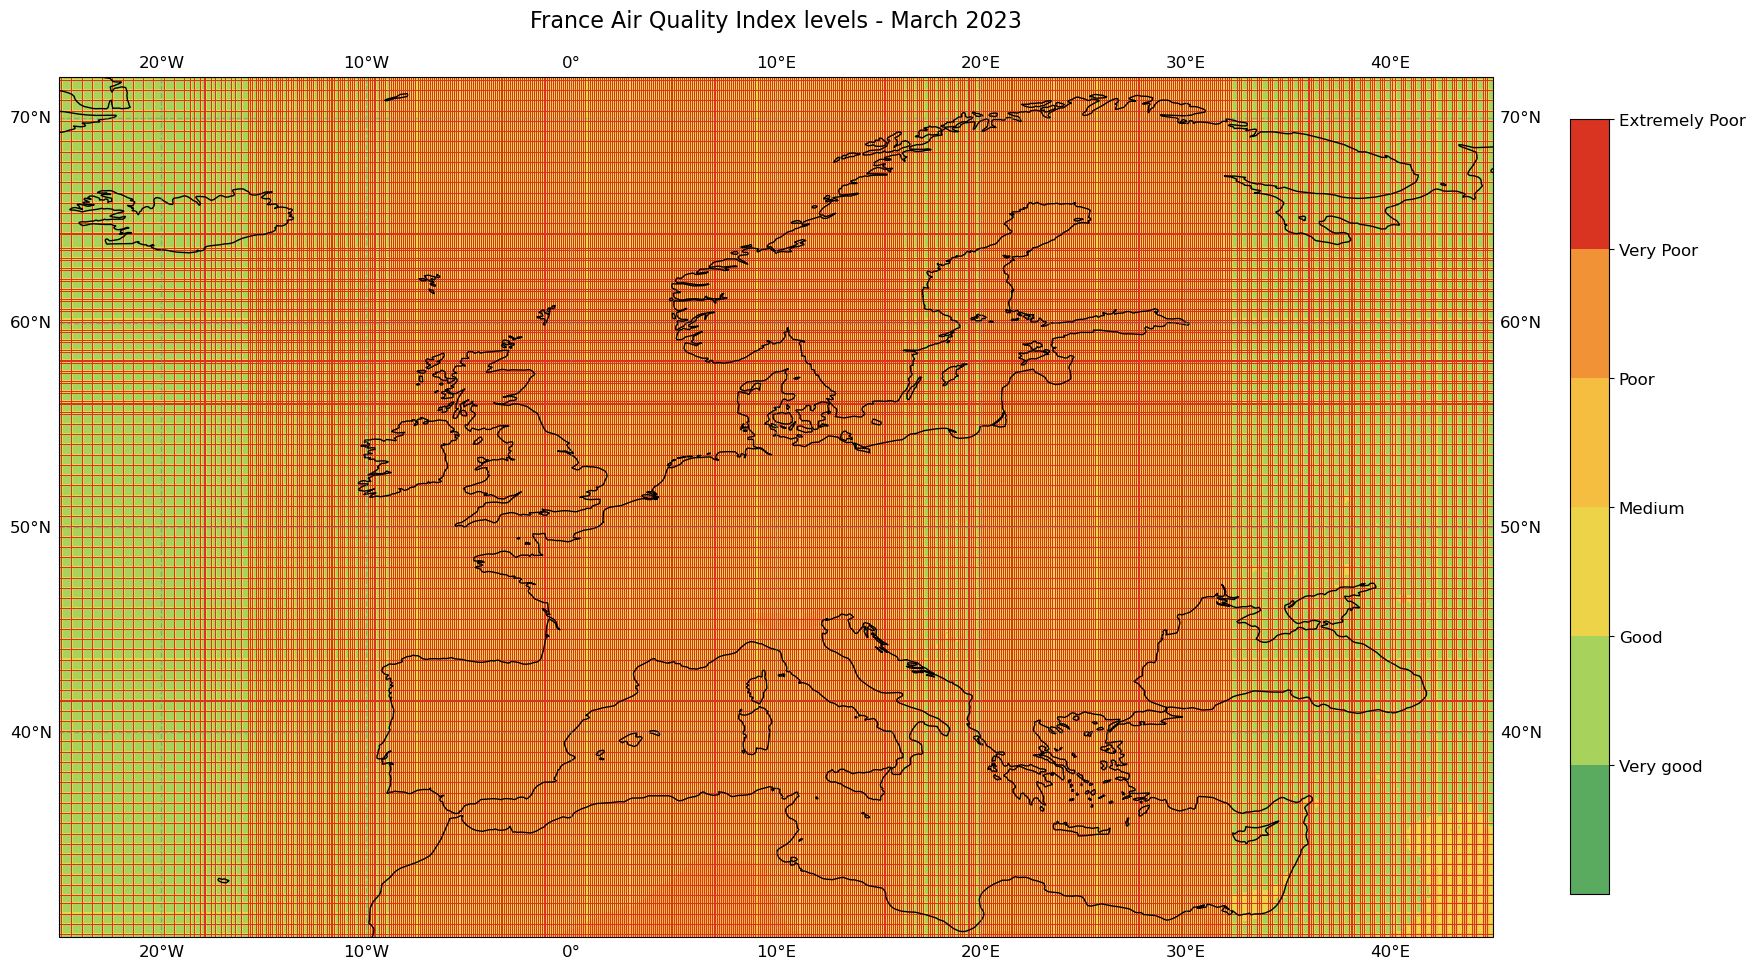

In [10]:
fig = plt.figure(figsize=(20,15))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

vmin = 0
vmax = len(labels)

img = plt.pcolormesh(aq_index.lon, 
                     aq_index.lat, 
                     aq_index, 
                     cmap=cmap,
                     vmin=vmin,
                     vmax=vmax,
                     label=labels)

ax.set_title('France Air Quality Index levels - March 2023', fontsize=16, pad=20.0)

#ax.set_xlim(-5.16, 10.46)
#ax.set_ylim(40.85, 50.71)

# Customize colorbar
cbar = plt.colorbar(img,fraction=0.025, pad=0.05)
cbar.set_label(None)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([1,2,3,4,5,6])
cbar.set_ticklabels(labels)

# Add additional features such as coastlines and a geographic grid
ax.coastlines(color='black')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style={'size':12}
gl.ylabel_style={'size':12}

In [11]:
canton_points = gpd.read_file('../input/canton_points.gpkg')
canton_points

,can_code,can_name,can_name_up,can_name_lo,geometry
0,['7819'],['Verneuil-sur-Seine'],VERNEUIL SUR SEINE,verneuil-sur-seine,POINT (1.97317 48.91519)
1,['7903'],['Celles-sur-Belle'],CELLES SUR BELLE,celles-sur-belle,POINT (-0.07842 46.30673)
2,['7904'],['Cerizay'],CERIZAY,cerizay,POINT (-0.57884 46.75083)
3,['7907'],['Mauléon'],MAULEON,mauléon,POINT (-0.59815 46.96082)
4,['7908'],['Melle'],MELLE,melle,POINT (-0.0345 46.13387)
...,...,...,...,...,...
2049,['6231'],['Lillers'],LILLERS,lillers,POINT (2.52187 50.57827)
2050,['6702'],['Bouxwiller'],BOUXWILLER,bouxwiller,POINT (7.56718 48.72967)
2051,['6707'],['Illkirch-Graffenstaden'],ILLKIRCH GRAFFENSTADEN,illkirch-graffenstaden,POINT (7.7295 48.49898)
2052,['7004'],['Héricourt-2'],HERICOURT 2,héricourt-2,POINT (6.68423 47.59104)


In [12]:
lon = canton_points.geometry.x.values
lat = canton_points.geometry.y.values

In [13]:
coords = xr.DataArray(list(zip(lon, lat)), dims=["points", "dim"], coords={"dim": [0, 1]})

In [14]:
extended_ds_var = ds_var + ['aq_index']

values_dict = {}

for var in extended_ds_var:
    if var in ds_aq_monthly:
        values_dict[var] = ds_aq_monthly[var].sel(lon=coords[:, 0], lat=coords[:, 1], method='nearest').values
    elif var == 'aq_index':
        values_dict[var] = aq_index.sel(lon=coords[:, 0], lat=coords[:, 1], method='nearest').values

for var in extended_ds_var:
    canton_points[var] = values_dict[var].tolist()

In [15]:
canton_points.to_file('../intermediates/cams_aq_index_extracted.gpkg', driver='GPKG')

In [16]:
print(canton_points.head())

   can_code                can_name         can_name_up         can_name_lo  \
0  ['7819']  ['Verneuil-sur-Seine']  VERNEUIL SUR SEINE  verneuil-sur-seine   
1  ['7903']    ['Celles-sur-Belle']    CELLES SUR BELLE    celles-sur-belle   
2  ['7904']             ['Cerizay']             CERIZAY             cerizay   
3  ['7907']             ['Mauléon']             MAULEON             mauléon   
4  ['7908']               ['Melle']               MELLE               melle   

                    geometry       no2         o3       pm10      pm2p5  \
0   POINT (1.97317 48.91519)  9.408085        NaN  13.297861   9.065105   
1  POINT (-0.07842 46.30673)       NaN  82.912155        NaN        NaN   
2  POINT (-0.57884 46.75083)       NaN  83.616943        NaN        NaN   
3  POINT (-0.59815 46.96082)       NaN  83.768959        NaN        NaN   
4   POINT (-0.0345 46.13387)  4.073992        NaN  15.099453  10.412611   

        so2  aq_index  
0  0.874958         2  
1       NaN         6  
2 